In [1]:
import os
files = [i for i in os.listdir() if 'label_' in i]

In [2]:
import json
import re
line_sep = r'[\n\r]+'
data = []
import codecs
for filename in files:
    coder = filename.split('_')[1].split('.')[0]
    with codecs.open(filename,'r','utf-8') as f:
        s = f.read()
        l = re.split(line_sep,s)[0:-1]#.split('\n\r')[0:-1]
        for d in l:
            d = json.loads(d)
            d['coder'] = coder
            data.append(d)
import pandas as pd
df = pd.DataFrame(data)
# fix error with missing true cat in the beginning
import pickle
sample,class2num = pickle.load(open('validate_dependencies.pkl','rb'))
pol_df = pd.read_csv('base_dataframe.csv')
import pickle
#base = '/home/snorre/Dropbox/Forskning/bigdata/data_inspections/'
#pol_df,noise_df, Index = pickle.load(open(base+'topic_simulation_dependencies.pkl','rb'))
#class2num2 = dict(pol_df[['topic','topic_class']].values)
#class2num2 = sorted(class2num2,key=lambda x: class2num2[x])

#class2class = dict(zip(class2num,class2num2))



def get_dic_name(num):
    return class2english[class2class[class2num[int(num)]]]
#topicnum2english = [get_dic_name(i) for i in range(len(class2class))]
#json.dump(topicnum2english,open('topicnum2english','w'))
                    
class2english = {'kunst _musik_museum_kulturpol': 'Culture', ' klima_ miljø _ naturen ': 'Environment',
                 'undervis_folkeskole_ungdomsuddan': 'Education', 'udenrig_ forsvaret _militær': 'Foreign affairs',
                 ' EU _ eu': 'EU', ' sundhed': 'Health',
                 'indvandr_flygt_udlænding': 'Immigration', ' beskæftig': 'Employment', 'skat': 'Taxes', 
                 'forskning_ universitet_videregående udd': 'Science',
                 ' religi_ værdipol': 'Religion', ' økonom_ vækst': 'Economy', 
                 'kriminal_kriminel': 'Crime', 'hjemmehjælp_ ældre _ pension_ plejehjem': 'Elder care',
                 'fattig_socialt udsat_socialminis_svageste': 'Social policy'}
len(df)

1446

In [3]:
# make weighing scheme by the prevalence of each class.
class_weight = (pol_df.topic_class.value_counts().sort_index()).values

In [4]:
topicnum2english = json.load(open('topicnum2english','r'))
def get_dic_name(num):
    return topicnum2english[int(num)]

In [5]:
for i in range(15):
    get_dic_name(i)

In [6]:
df.groupby('coder').size(),len(df)

(coder
 slf    574
 sr      59
 ss     813
 dtype: int64, 1446)

In [107]:
1440/(15*15)

6.4

In [278]:
len(df)-df.id.nunique()

361

In [279]:
(df.id.value_counts()-1).sum()

361

In [6]:
id2topic = dict(sample[['id','topic_class']].values)

In [54]:
len(id2topic),df.id.nunique()

(1787, 1079)

In [7]:
df['true']=df.true.apply(lambda x: 'y' if x=='7' else x)
len(df)
df['TRUE'] = df.true.apply(lambda x: x=='y')

In [8]:
df['true_cat'] = df.id.apply(lambda x: id2topic[x])

In [9]:
df['weight'] = df.category.apply(lambda x: class_weight[int(x)])

In [10]:
df['weight2'] = df.true_cat.apply(lambda x: class_weight[int(x)])

In [10]:
#df.groupby('id').apply(lambda x: if len(x)>1,
#Counter(df.id)

In [11]:
df['random'] = df.category!=df.true_cat
#df[df.TRUE][['id','category']]

## Combining the Two Evaluation Types.

- Is this right --> A label (either neg or pos) if category was true. If category False only 
- Exhaustive label --> Label pos and neg.

In [12]:
import numpy as np
def is_in(val,simple=True):
    
    vals = df[['category','true_cat','classes','TRUE']].values
    temp = []
    if not simple:
        for cat,tcat,classes,boolean in vals:

            if val==cat:
                if boolean:
                    temp.append(1)
                else:
                    temp.append(-1)
                continue
            elif type(classes)==list:
                if val in classes:
                    temp.append(1)
                else:            
                    #if val==tcat:
                     #   temp.append(-2) # then it was explicitly rejected.
                    #else:
                    temp.append(0) # then it might have been forgotten.
            else:
                temp.append(np.nan)
    else:
        for cat,tcat,classes,boolean in vals:
            if val==cat:
                if boolean:
                    temp.append(1)
                else:
                    temp.append(0)
            else:
                temp.append(np.nan)
    return temp
        
    # next get category
    
    
for i in range(15):
    df[i] = is_in(i)

In [13]:
import numpy as np
def get_agreements(df):
    agreements = {'category':[],'aggreement':[],'n':[],'true_count':[]}
    cats = []
    for cat,groupdf in df.groupby('true_cat'):
        vals = groupdf.groupby('id').apply(lambda x: (len(set(x.TRUE))==1)*1 if (len(x)>1 and x.category.nunique()==1)else np.nan)
        agreement = np.nanmean(vals)
        #print(cat,get_dic_name(cat),agreement,sum(np.isfinite(vals)))
        #agreements.append(agreement)
        agreements['category'].append(get_dic_name(cat))
        agreements['aggreement'].append(agreement)
        agreements['n'].append(sum(np.isfinite(vals)))
        agreements['true_count'].append(np.nansum(vals))
    return pd.DataFrame(agreements)
agreement_df = get_agreements(df)
temp = get_agreements(df[df['random']])
temp.columns = ['category','agreement_random','n_random','true_count_random']
agreement_df = agreement_df.merge(temp)
temp = get_agreements(df[~df['random']])
temp.columns = ['category','agreement_true','n_true','true_count_true']
agreement_df = agreement_df.merge(temp)

<ipython-input-13-17ce63765a41>:7: RuntimeWarning: Mean of empty slice
  agreement = np.nanmean(vals)


In [15]:
all_n = agreement_df.n_true.sum()+agreement_df.n_random.sum() # only two where they got the same id and same "false" label
n_agg = agreement_df.true_count_true.sum() + agreement_df.agreement_random.sum()
n_agg/all_n

0.85

In [ ]:
matched_categories = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0]

In [100]:
sum(np.random.binomial(1,0.5,size=1000)==np.random.binomial(1,0.5,size=1000))


510

In [102]:
mat.sum(axis=1)

Culture             80
Environment        112
Education           93
Foreign affairs     97
EU                  93
Health              98
Immigration         95
Employment          94
Taxes               98
Science             94
Religion            98
Economy             83
Crime              103
Elder care         104
Social policy       98
dtype: int64

In [16]:
sample = df.copy()
sample['dummy'] = 1
n_cats = sample.true_cat.nunique()
mat = sample.groupby(['category','true_cat']).dummy.sum().unstack(fill_value=0).stack().values.reshape(n_cats,n_cats)

In [17]:
#sample[sample.random].shape
#702/(225-15)

In [21]:
import seaborn as sns
%matplotlib inline
#sns.heatmap((mat.T/mat.sum(axis=1)).T)

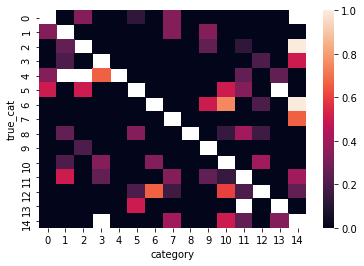

## Precision and Recall

In [211]:
df.groupby('TRUE')['weight'].sum()/df.weight.sum(),df.groupby('TRUE')['weight2'].sum()/df.weight2.sum()

(TRUE
 False    0.513064
 True     0.486936
 Name: weight, dtype: float64, TRUE
 False    0.509596
 True     0.490404
 Name: weight2, dtype: float64)

In [22]:
#(df['TRUE']*df['weight2']).sum()/df['weight2'].sum()

In [14]:
sample = df.copy()
sample['dummy'] = 1
precision_df = pd.DataFrame(sample[~sample.random].groupby('true_cat')['TRUE'].mean()).reset_index()
precision_df.columns = ['category','precision']
precision_df['label'] = precision_df.category.apply(get_dic_name)#.unstack(fill_value=np.nan)

In [26]:
#temp['label'] = temp.category.apply(get_dic_name)

In [218]:
#temp.sort_values('weighted_precision')

In [15]:
precision_df.sort_values('precision')[['label','precision']]


,label,precision
9,Science,0.729167
12,Crime,0.800000
5,Health,0.808511
3,Foreign affairs,0.812500
11,Economy,0.829268
13,Elder care,0.844828
2,Education,0.846154
4,EU,0.862745
0,Culture,0.878049
10,Religion,0.888889


## How often was a category overlooked?
Use only the ones where the provided label was false. And then see how many times it was believed to be true.

In [30]:
import matplotlib.pyplot as plt
def get_weighted(groupdf,ref='true'):
  #  print(ref)
    if ref=='true':
        w = groupdf['weight2'].values
        v = groupdf['TRUE'].values*1.0
        #print(w.dot(v)/sum(w),sum(v)/len(v),w)
        return w.dot(v)/sum(w)
        #return ((groupdf.TRUE*1.0) * groupdf['weight']).sum()/groupdf.weight.sum()
    if ref=='random':
        w = groupdf['weight2'].values
        v = groupdf['TRUE'].values*1.0
        print(list(zip(v,w,groupdf.category)))
   #     print(w.dot(v)/sum(w)==sum(v)/len(v),w)
        return w.dot(v)/sum(w)
        return ((groupdf.TRUE*1.0) * groupdf['weight2']).sum()/groupdf.weight2.sum()

plt.figure(figsize=(12,8))
overlooked_df = sample[sample.random].groupby('category')['TRUE'].mean().reset_index()
overlooked_df.columns = ['category','percentage']
temp = pd.DataFrame(sample[sample.random].groupby('category').apply(get_weighted).reset_index())
temp.columns = ['category','weighted_percentage']
overlooked_df = overlooked_df.merge(temp)
overlooked_df['label'] = overlooked_df.category.apply(get_dic_name)#.unstack(fill_value=np.nan)
overlooked_df['recall'] = 1-overlooked_df['percentage']
overlooked_df['weighted_recall'] = 1-overlooked_df['weighted_percentage']
overlooked_df.sort_values('percentage')[['label','recall','weighted_recall']]

#mat.columns = [get_dic_name(i) for i in mat.columns]
#mat.index = mat.columns
#sns.heatmap(mat,annot=True)

,label,recall,weighted_recall
4,EU,1.000000,1.000000
8,Taxes,1.000000,1.000000
13,Elder care,0.956522,0.965965
6,Immigration,0.942308,0.948245
2,Education,0.930233,0.943659
5,Health,0.921569,0.935922
12,Crime,0.915254,0.912128
9,Science,0.913043,0.893339
1,Environment,0.907407,0.866701
0,Culture,0.897436,0.881482


<Figure size 864x576 with 0 Axes>

In [267]:
overlooked_df.weighted_recall.mean(),overlooked_df.recall.mean()

(0.8941632055972817, 0.8994778651483962)

In [33]:
f1_df = overlooked_df.merge(precision_df)

In [35]:
np.array([3,2]).prod()

6

In [38]:
f1_df = overlooked_df.merge(precision_df)
f1_df['f1'] = f1_df[['precision','weighted_recall']].apply(lambda x: (2*x.prod())/x.sum(),axis=1)

In [76]:

#f1_df['f1'] = f1_df[['precision','weighted_recall']].sum(axis=1)/2

In [42]:
f1_df['category'] = f1_df.label

In [73]:
f1_df.to_csv('category2performance.csv',index=False)

In [43]:
import tabulate
print(tabulate.tabulate(f1_df.sort_values('f1',ascending=False)[['category','f1','precision','weighted_recall']], tablefmt="pipe"
                        , headers="keys",showindex=False,floatfmt='.2g'))
#f1_df.sort_values('f1')[['label','f1','precision','weighted_recall']]

| category        |   f1 |   precision |   weighted_recall |
|:----------------|-----:|------------:|------------------:|
| Immigration     | 0.96 |        0.98 |              0.95 |
| Taxes           | 0.96 |        0.91 |              1    |
| EU              | 0.93 |        0.86 |              1    |
| Employment      | 0.91 |        0.94 |              0.88 |
| Elder care      | 0.9  |        0.84 |              0.97 |
| Environment     | 0.9  |        0.93 |              0.87 |
| Education       | 0.89 |        0.85 |              0.94 |
| Culture         | 0.88 |        0.88 |              0.88 |
| Health          | 0.87 |        0.81 |              0.94 |
| Crime           | 0.85 |        0.8  |              0.91 |
| Foreign affairs | 0.84 |        0.81 |              0.86 |
| Economy         | 0.83 |        0.83 |              0.83 |
| Religion        | 0.83 |        0.89 |              0.77 |
| Social policy   | 0.8  |        0.91 |              0.72 |
| Science         | 0.8 

In [ ]:
plt.figure(figsize=(12,8))
mat = sample[sample.random].groupby(['category','category'])['TRUE'].mean().unstack(fill_value=np.nan)
mat.columns = [get_dic_name(i) for i in mat.columns]
mat.index = mat.columns
sns.heatmap(mat,annot=True)

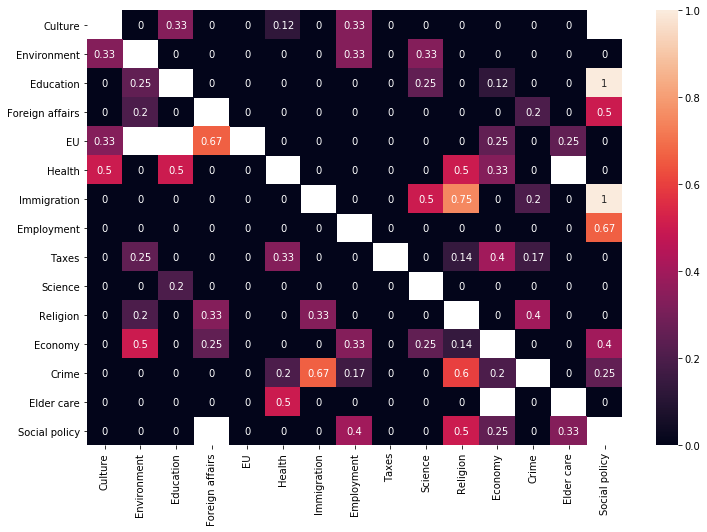

In [46]:
plt.figure(figsize=(12,8))
mat = sample[sample.random].groupby(['true_cat','category'])['TRUE'].mean().unstack(fill_value=np.nan)
mat.columns = [get_dic_name(i) for i in mat.columns]
mat.index = mat.columns
sns.heatmap(mat,annot=True)
plt.savefig('output/descriptives/confusion_matrix_dictionaries.png')

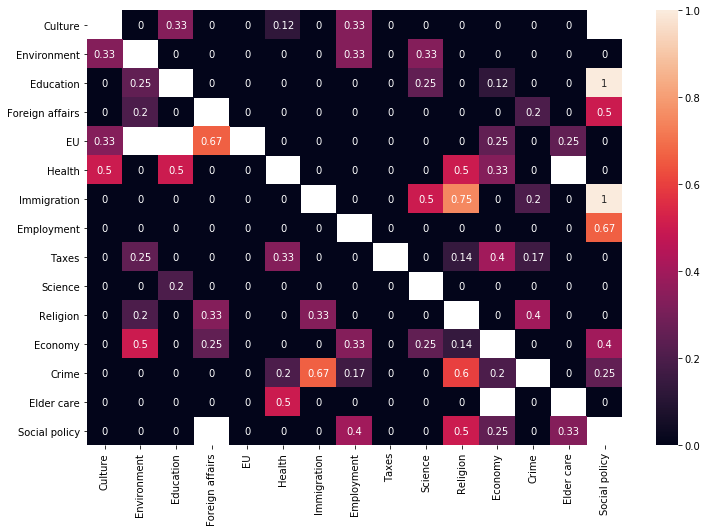

In [136]:
plt.figure(figsize=(12,8))
mat = sample[sample.random].groupby(['true_cat','category'])['TRUE'].mean().unstack(fill_value=np.nan)
mat.columns = [get_dic_name(i) for i in mat.columns]
mat.index = mat.columns
sns.heatmap(mat,annot=True)

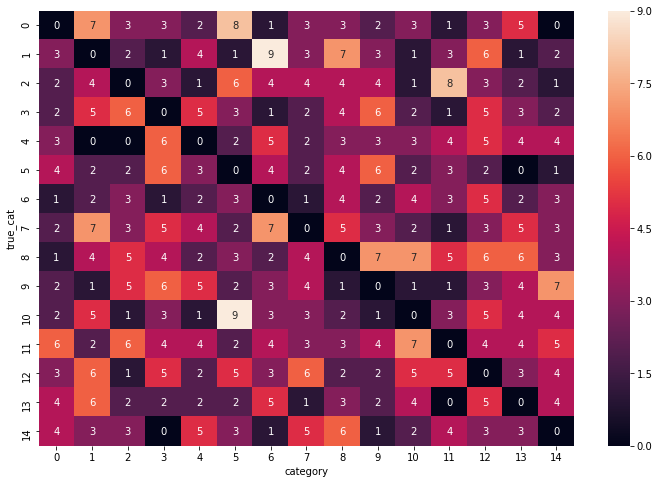

In [130]:
plt.figure(figsize=(12,8))
sns.heatmap(sample[sample.random].groupby(['true_cat','category'])['TRUE'].size().unstack(fill_value=0),annot=True)

In [118]:
sample

,category,classes,coder,id,t,t2,true,true_cat,TRUE,0,...,7,8,9,10,11,12,13,14,random,dummy
0,12,NaN,slf,561507140593570_712142265530056,1.529651e+09,NaN,,7,False,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,True,1
1,13,NaN,slf,561507140593570_817890808288534,1.529651e+09,NaN,,13,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,False,1
2,7,NaN,slf,335987446552987_568416216643441,1.529651e+09,NaN,y,7,True,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1
3,12,NaN,slf,223155564511824_481816371979074,1.529651e+09,NaN,,11,False,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,True,1
4,9,NaN,slf,411433282329295_670352776437343,1.529651e+09,NaN,,9,False,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,False,1
5,0,NaN,slf,952334508116178_1431056290243995,1.529651e+09,NaN,,2,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1
6,13,NaN,slf,547569822031033_801801699941176,1.529652e+09,NaN,,9,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,True,1
7,5,NaN,slf,143586919135944_211105255717443,1.529652e+09,NaN,y,13,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1
8,13,NaN,slf,384119014960360_807201919318732,1.529652e+09,NaN,,8,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,True,1
9,2,NaN,slf,252520351444054_1150260818336665,1.529652e+09,NaN,,0,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1


0.02666666666666667


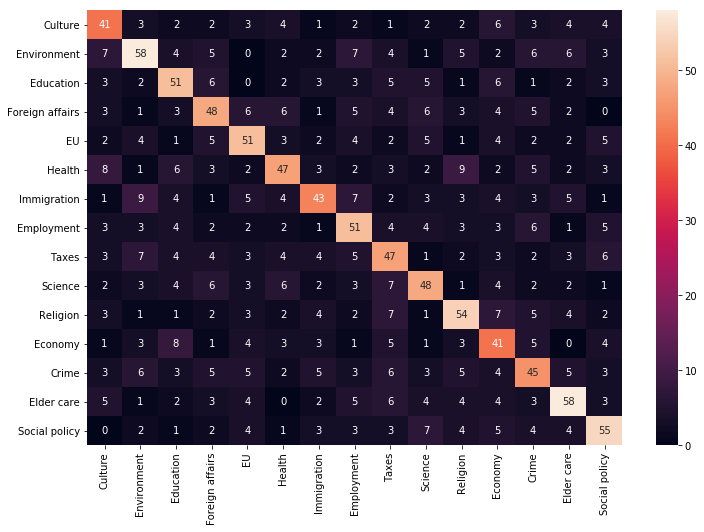

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,8))
mat = pd.DataFrame(mat,columns=[get_dic_name(i) for i in range(n_cats)]
                   ,index=[get_dic_name(i) for i in range(n_cats)])
sns.heatmap(mat,annot=True)
print(sum(mat.values.flatten()==0)/mat.values.size)

In [77]:
print('We need at least %d samples from each pair amounting to %d'%(10,mat.size * 10))

We need at least 10 samples from each pair amounting to 2250


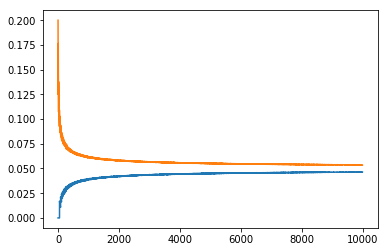

In [99]:
quintiles = []
for n_pair in range(10,10000):

    vals=np.random.binomial(n_pair,p=0.05,size=10000)/n_pair
    quintiles.append((np.quantile(vals,q=0.05),np.quantile(vals,q=0.95)))
plt.plot(quintiles)

In [9]:

agreements = []
for cat,groupdf in df[df.category==df.true_cat].groupby('true_cat'):
    vals = groupdf.groupby('id').apply(lambda x: (len(set(x.TRUE))==1)*1 if len(x)>1 else np.nan)
    agreement = np.nanmean(vals)
    print(cat,get_dic_name(cat),agreement,sum(np.isfinite(vals)))
    agreements.append(agreement)

np.nanmean(df[df.category==df.true_cat].groupby('id').apply(lambda x: (len(set(x.TRUE))==1)*1 if len(x)>1 else np.nan))

0 Culture 1.0 4
1 Environment 0.8571428571428571 7
2 Education 0.875 8
3 Foreign affairs 1.0 4
4 EU 0.8 10
5 Health 0.8333333333333334 6
6 Immigration 1.0 8
7 Employment 1.0 5
8 Taxes 0.6 5
9 Science 0.6666666666666666 6
10 Religion 1.0 6
11 Economy 0.8333333333333334 6
12 Crime 0.4 5
13 Elder care 1.0 6
14 Social policy 0.875 8


0.851063829787234

In [26]:
print(np.mean(agreements))

0.8493650793650793


In [22]:
from collections import Counter
#np.nanmean(df[df.category==df.true_cat].groupby('id').apply(lambda x: (Counter(x.TRUE).most_common(1)[0][1]>1)*1 if len(x)>1 else np.nan))

In [22]:

unweighed_accuracy = 1 - sum(df[df.category!=df.true_cat].TRUE)/len(df[df.category!=df.true_cat]) 
print(unweighed_accuracy)
## the weighed accuracy is based on the base probs of the other. 
label_counts = pol_df.topic_class.value_counts()
label_fracs  = label_counts/label_counts.sum()
label_fracs = dict(label_fracs)
label_fracs
df['weight'] = df.true_cat.apply(lambda x: label_fracs[x])
errors = df[df.category!=df.true_cat]
weighed_accuracy = 1 - sum((errors.TRUE*errors.weight))/sum(errors.weight)
print(weighed_accuracy)                      

0.9017094017094017
0.895237015340787


In [44]:
import sklearn.metrics

performance = []    
for i in range(15):
    tempdf = df[df[i].apply(np.isfinite)]
    ytest = tempdf[i].values
    weight = tempdf.weight.values
    ypred = (tempdf.true_cat==i).values*1.0
    #sklearn.metrics.
    true = ytest==ypred
    acc = sum(true)/len(ytest)
    acc_weight = (true*weight).sum()/(np.ones(len(true))*weight).sum()
    recall,precision = sklearn.metrics.recall_score(ytest,ypred),sklearn.metrics.precision_score(ytest,ypred)
    recall_w,precision_w = sklearn.metrics.recall_score(ytest,ypred,sample_weight=weight),sklearn.metrics.precision_score(ytest,ypred,sample_weight=weight)
    d = {'topic_name':get_dic_name(i),'n':len(tempdf),'recall':recall,'recall_w':recall_w,
        'accuracy':acc,'accuracy_w':acc_weight,'precision_w':precision_w,'precision':precision,
        'topic':i}
    performance.append(d)
performance = pd.DataFrame(performance)

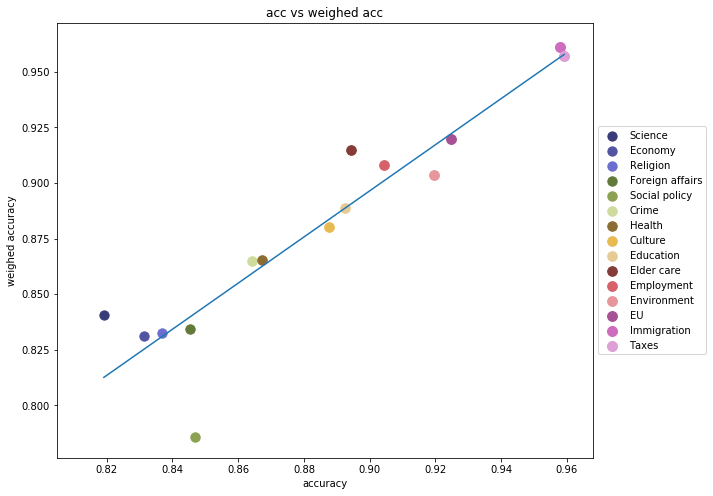

In [64]:
def linear_func(x, a, b):
    return a*x + b
from scipy.optimize import curve_fit
def fit_function(x,y,func=linear_func,plot=False):
    popt, pcov = curve_fit(func, x, y)
    xlim = np.linspace(min(x),max(x),50)
    fit_y = func(xlim,*popt)
    return xlim,fit_y

def plot_dictionary_stats(df,funcx,funcy,xlabel='',ylabel='',fitline = True,sort_column='n_docs',hue='topic_name',title='Proportions and Matches'):
    fig = plt.figure(figsize=(12,8))
    ax = plt.subplot(111)
    cmap = plt.cm.get_cmap('tab20b', 15)
    #xcol,ycol = 'n_docs','n_accepted'
    max_ =df[sort_column].max()
    
    for num,(label,tempdf) in enumerate(df.sort_values(sort_column).groupby(hue,sort=False)):
        color = cmap(num/15)
        size = tempdf[sort_column].values
        ax.scatter(funcx(tempdf),funcy(tempdf),label=label,c=color,s=(tempdf[sort_column].values[0]/max_)*100)# c=tempdf.topic, cmap=plt.cm.get_cmap('Spectral', 15)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # plot linear expectancy
    if fitline:
        xlim,ypred = fit_function(funcx(df).values,funcy(df).values)
        plt.plot(xlim,ypred)
    #x,y = matches[xcol],matches[ycol]
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return ax
import matplotlib.pyplot as plt
%matplotlib inline
plot_dictionary_stats(performance,lambda x: x.accuracy,lambda x: x.accuracy_w,xlabel='accuracy',ylabel='weighed accuracy',sort_column='accuracy',title='acc vs weighed acc')

In [65]:
performance.to_csv('dictionary_performance.csv',index=False)

In [ ]:
tempdf


In [178]:
def make_accum_label(groupdf):
    temp = []
    for i in range(15):
        if len(groupdf[i].dropna())==0:
            temp.append(np.nan)
            continue
        if 1 in groupdf[i].values:
            temp.append(1)
        else:
            temp.append(0)
        #counts = groupdf[i].value_counts()
        #aggreement = counts.values[0] / len(counts)
        #if 1 in counts.index:
        #    return 1
    return pd.DataFrame([temp])
def make_prob_label(groupdf):
    temp = []
    for i in range(15):
        
        counts = groupdf[i].value_counts()
        aggreement = counts.values[0] / len(counts)
        if 1 in counts.index:
            return 1
        true = max(counts.index)
    return 
label_dummy = df[['id']+list(range(15))].groupby('id').apply(make_accum_label).reset_index().drop('level_1',axis=1)#
label_dummy['weight'] = df['weight']
label_dummy.to_csv('simple_labels.csv',index=False)


In [2]:
label_dummy

NameError: name 'label_dummy' is not defined

In [172]:
#label_dummy

In [175]:
for i in range(15):
    print(get_dic_name(i),len(label_dummy[i].dropna()))

Culture 76
Environment 105
Education 85
Foreign affairs 92
EU 83
Health 91
Immigration 86
Employment 89
Taxes 93
Science 88
Religion 92
Economy 77
Crime 98
Elder care 97
Social policy 90


In [173]:
label_dummy.sum(axis=0)

id          inf
0     36.000000
1     53.000000
2     40.000000
3     41.000000
4     36.000000
5     37.000000
6     36.000000
7     49.000000
8     40.000000
9     36.000000
10    52.000000
11    36.000000
12    40.000000
13    44.000000
14    53.000000
dtype: float64

In [136]:
for i in range(15):
    
    temp = df[i].dropna() 
    print(get_dic_name(i),len(temp),temp.value_counts())

Culture 1107  0.0    1027
 1.0      40
-1.0      40
Name: 0, dtype: int64
Environment 1115  0.0    1003
 1.0      59
-1.0      53
Name: 1, dtype: int64
Education 1105  0.0    1012
 1.0      47
-1.0      46
Name: 2, dtype: int64
Foreign affairs 1111  0.0    1014
-1.0      52
 1.0      45
Name: 3, dtype: int64
EU 1106  0.0    1013
-1.0      49
 1.0      44
Name: 4, dtype: int64
Health 1116  0.0    1018
-1.0      56
 1.0      42
Name: 5, dtype: int64
Immigration 1111  0.0    1016
-1.0      50
 1.0      45
Name: 6, dtype: int64
Employment 1104  0.0    1010
 1.0      54
-1.0      40
Name: 7, dtype: int64
Taxes 1107  0.0    1009
-1.0      55
 1.0      43
Name: 8, dtype: int64
Science 1110  0.0    1016
-1.0      55
 1.0      39
Name: 9, dtype: int64
Religion 1110  0.0    1012
 1.0      58
-1.0      40
Name: 10, dtype: int64
Economy 1106  0.0    1023
-1.0      42
 1.0      41
Name: 11, dtype: int64
Crime 1107  0.0    1004
-1.0      62
 1.0      41
Name: 12, dtype: int64
Elder care 1113  0.0   

In [9]:
#df.true_cat.value_counts()

In [50]:
%matplotlib inline


In [109]:
label_counts = df[df.TRUE].category.value_counts().sort_index()
believed_counts = df[df.TRUE].true_cat.value_counts().sort_index()
## over- underestimations
correction_df = pd.DataFrame((label_counts-believed_counts)/believed_counts).reset_index()
correction_df.columns = ['topic_class','overestimation']
correction_df['topic'] = correction_df.topic_class.apply(get_dic_name)

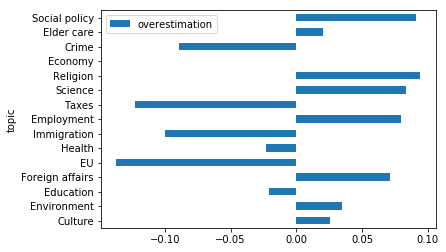

In [111]:
correction_df.index = correction_df.topic

(correction_df.drop('topic_class',axis=1)).plot(kind='barh')

In [7]:
len(df[df['coder'] == 'slf'])

574

sr 0.596750545170572
Series([], Name: classes, dtype: float64)
ss 4.158859567708439
1    0.756798
2    0.200906
3    0.025680
4    0.015106
5    0.001511
Name: classes, dtype: float64
slf 4.772738740642866
1    0.839243
2    0.132388
3    0.021277
4    0.007092
Name: classes, dtype: float64


C:\Users\jbv933\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  
C:\Users\jbv933\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  from ipykernel import kernelapp as app


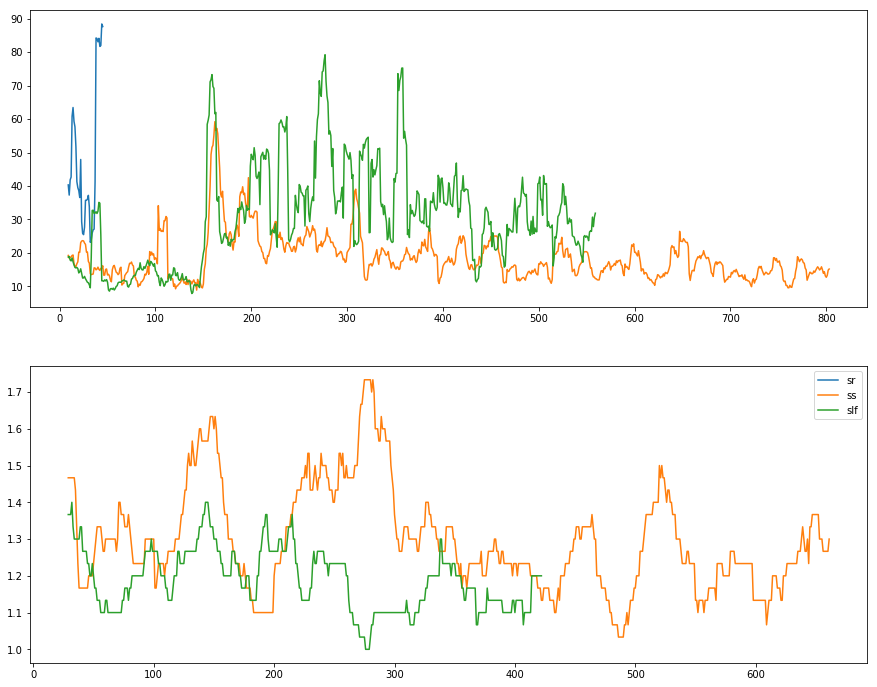

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
fig,ax = plt.subplots(2)
for coder in set(df.coder):
    
    sub = df[df['coder'] == coder]
    n_vals = sub[sub.classes.apply(type)==list].classes.apply(len)
    class_count = n_vals.value_counts()
    class_count = class_count/class_count.sum()
    delta = (sub.t - sub.t.shift(1)).dropna() 
    print(coder,sum(delta[delta<500])/3600)
    print(class_count)
    ax[0].plot(pd.rolling_mean(delta[delta<500],window=10).values,label=coder)#.plot(label=coder)
    ax[1].plot(pd.rolling_mean(n_vals,window=30).values,label=coder)
plt.legend()
fig.set_size_inches(15,12)

In [21]:
sum(delta[delta<500])/3600

4.772738740642866

In [9]:
import numpy as np
def isin_categories(row):
    cat = str(row['true_cat'])
    if type(row['classes'])==float:
        return np.nan
    classes = set(row['classes'])
    
    if cat in classes:
        return True
    else:
        return False
df['Match'] = df.apply(isin_categories,axis=1)
df.Match.value_counts()

True     851
False    234
Name: Match, dtype: int64

In [10]:
df['validated2'] = df['Match'] #| df.validate
counts = df[df['Match']!=np.nan].validated2.value_counts()#df.Match.value_counts()
counts[True]/sum(counts)

0.784331797235023

# Performance F1 scores

In [60]:
categories = sorted(set(df.category))
# count number of missing pr trick. # df.trick is True if not trick argg!!!
tricks = df[~df.trick]
wrong = []
PRECISION = []
for cat in categories:
    sub = tricks[tricks.category==cat] # 10 percent chance of being wrong.
    print(class2num[int(cat)],sum(sub['TRUE'])/len(sub))
    wrong.append(sum(sub['TRUE'])/len(sub))
    sub = df[df['category']==cat]

kunst_musik_museum_kulturpolitik 0.10256410256410256
 klima_miljø_naturen  0.09259259259259259
undervisning_folkeskole_ungdomsuddanelse 0.07142857142857142
udenrigspolitik_ forsvaret _militær 0.12244897959183673
 EU 0.0
Sundhed 0.0784313725490196
Indvandrer_flygtninge_udlændinge 0.057692307692307696
beskæftigelsespolitik_arbejdsløshed 0.13953488372093023
Skat 0.0
Forskning_ universitet_videregående udd 0.08695652173913043
Religion_værdipolitik 0.22727272727272727
økonomi_vækst 0.16666666666666666
kriminalitet_kriminelle_grænsekontrol 0.08620689655172414
hjemmehjælp_ældre_ pension_ plejehjem 0.043478260869565216
fattig_socialt udsatte_socialministeriet_svageste 0.23255813953488372


In [48]:
# count number of false.
wrong2 = []
not_tricks = df[df.trick]
for cat in categories:
    sub = not_tricks[not_tricks.category==cat]
    print(class2num[int(cat)],1-(sum(sub['TRUE'])/len(sub)))
    wrong2.append(1-sub['TRUE'].sum()/len(sub))

kunst_musik_museum_kulturpolitik 0.12195121951219512
 klima_miljø_naturen  0.06896551724137934
undervisning_folkeskole_ungdomsuddanelse 0.13725490196078427
udenrigspolitik_ forsvaret _militær 0.1875
 EU 0.13725490196078427
Sundhed 0.19148936170212771
Indvandrer_flygtninge_udlændinge 0.023255813953488413
beskæftigelsespolitik_arbejdsløshed 0.05882352941176472
Skat 0.08510638297872342
Forskning_ universitet_videregående udd 0.27083333333333337
Religion_værdipolitik 0.11111111111111116
økonomi_vækst 0.1707317073170732
kriminalitet_kriminelle_grænsekontrol 0.19999999999999996
hjemmehjælp_ældre_ pension_ plejehjem 0.15517241379310343
fattig_socialt udsatte_socialministeriet_svageste 0.09090909090909094


In [56]:
import numpy as np
# average error
sum_ = [1-(w+w2) for w,w2 in zip(wrong,wrong2)] 
precisions = [1-w for w in wrong2] 
f1s = [((1-w)+(1-w2))/2 for w,w2 in zip(wrong,wrong2)] 

print(np.mean(sum_),np.mean(f1s),np.mean(precisions))

0.7654539128027321 0.8827269564013661 0.8659760476543361


In [ ]:
# averagef1 accross topic

In [11]:
df['trick'] = df['category']==df['true_cat']
sum(df.trick)

738

In [12]:
df['validate'] = (df['category']==df['true_cat']) & (df['true']=='y')


In [13]:
df['name'] = df.category.apply(lambda x: class2num[x])
no_trick = df[df.trick]

accuracy = no_trick.groupby('name').apply(lambda x: x.validate.sum()/len(x))

In [57]:
accuracy

name
 EU                                                  0.862745
 klima_miljø_naturen                                 0.931034
Forskning_ universitet_videregående udd              0.729167
Indvandrer_flygtninge_udlændinge                     0.976744
Religion_værdipolitik                                0.888889
Skat                                                 0.914894
Sundhed                                              0.808511
beskæftigelsespolitik_arbejdsløshed                  0.941176
fattig_socialt udsatte_socialministeriet_svageste    0.909091
hjemmehjælp_ældre_ pension_ plejehjem                0.844828
kriminalitet_kriminelle_grænsekontrol                0.800000
kunst_musik_museum_kulturpolitik                     0.878049
udenrigspolitik_ forsvaret _militær                  0.812500
undervisning_folkeskole_ungdomsuddanelse             0.862745
økonomi_vækst                                        0.829268
dtype: float64

In [59]:
#accuracy.mean()


0.8659760476543362

In [39]:
#accuracy

In [16]:
# construct confusion matrix.
confusion_mat = np.zeros((len(class2num),len(class2num)+1))
cat_counts = np.zeros(len(class2num))
for true_cat,categories in df[['true_cat','classes']].values:
    if type(categories)==float:
        continue
    
    cat_counts[true_cat]+=1
    for cat in categories:
        if '.' in cat:
            print('-',end='')
            for cat in cat.split('.'):
                cat = int(cat)
                confusion_mat[true_cat][cat]+=1
            continue
        if cat=='':
            confusion_mat[true_cat][-1]+=1
            continue
        cat = int(cat)
        confusion_mat[true_cat][cat]+=1
        

-

In [23]:
class2english = {'kunst _musik_museum_kulturpol': 'Culture', ' klima_ miljø _ naturen ': 'Environment',
                 'undervis_folkeskole_ungdomsuddan': 'Education', 'udenrig_ forsvaret _militær': 'Foreign affairs',
                 ' EU _ eu': 'EU', ' sundhed': 'Health',
                 'indvandr_flygt_udlænding': 'Immigration', ' beskæftig': 'Employment', 'skat': 'Taxes', 
                 'forskning_ universitet_videregående udd': 'Science',
                 ' religi_ værdipol': 'Religion', ' økonom_ vækst': 'Economy', 
                 'kriminal_kriminel': 'Crime', 'hjemmehjælp_ ældre _ pension_ plejehjem': 'Elder care',
                 'fattig_socialt udsat_socialminis_svageste': 'Social policy'}

english_names = list(class2english.values())
class2english2 = {i:english_names[num] for num,i in enumerate(class2num)}
#for i in class2num:
#    print(list(enumerate(english_names)))
#    val = english_names[int(input('WHich is this %s\n'%i))]
    

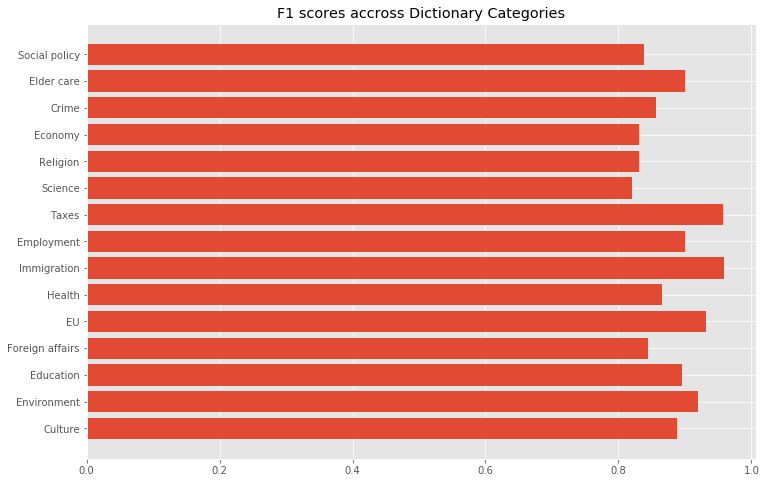

In [72]:
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.barh(range(len(english_names)),f1s)
plt.title('F1 scores accross Dictionary Categories')
plt.yticks(np.arange(len(english_names)),english_names)
plt.savefig('f1_barplot.png',dpi=1000)

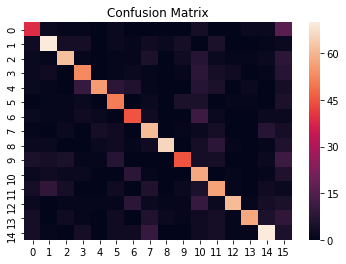

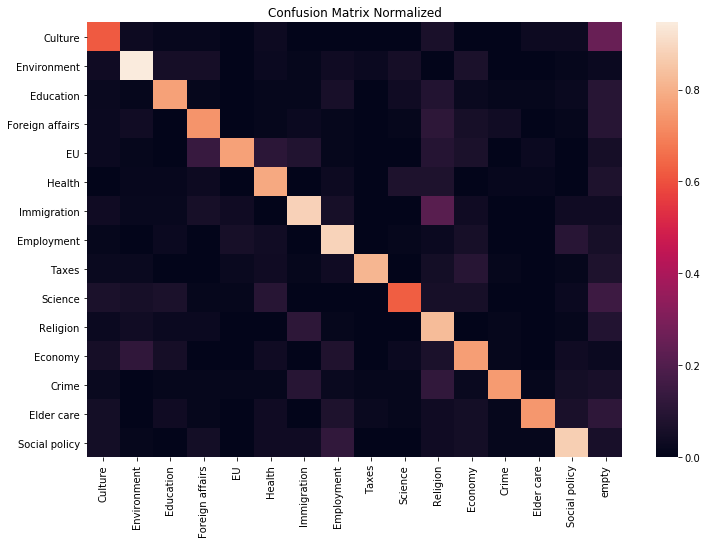

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mat = []
mat2 = []
for num,row in enumerate(confusion_mat):
    mat.append(row/row.sum())
    mat2.append(row/cat_counts[num])
sns.heatmap(confusion_mat)
plt.title('Confusion Matrix')
plt.figure(figsize=(12,8))
sns.heatmap(mat2)
plt.title('Confusion Matrix Normalized')
plt.yticks(np.arange(len(class2num))+0.5,[class2english2[i] for i in class2num],rotation=0);
plt.xticks(np.arange(len(class2num)+1)+0.5,[class2english2[i] for i in class2num]+['empty'],rotation=90);
#plt.yticks(class2num)
plt.savefig('confusion_matrix.png',dpi=1000)


In [27]:
f1s = []
for num,row in enumerate(confusion_mat):
    print(row[num]/row.sum(),row[num]/cat_counts[num])
    row/row.sum()
    #mat.append()
    mat2.append(row/cat_counts[num])
    

0.5652173913043478 0.6190476190476191
0.693069306930693 0.9459459459459459
0.6391752577319587 0.7654320987654321
0.6162790697674418 0.7361111111111112
0.5490196078431373 0.7671232876712328
0.6891891891891891 0.7846153846153846
0.6081081081081081 0.8823529411764706
0.6853932584269663 0.8840579710144928
0.6666666666666666 0.8148148148148148
0.5056179775280899 0.625
0.6904761904761905 0.8285714285714286
0.59375 0.76
0.6039603960396039 0.7530864197530864
0.58 0.7435897435897436
0.6422018348623854 0.875


In [35]:
df.validate.sum() /sum(df.trick)

0.8672086720867209

In [12]:
df.validate.sum() /sum(df.trick)

0.86709886547812

In [36]:
df.groupby('trick').apply(lambda x: x.true.value_counts()/len(x))

trick   
False       0.901709
       y    0.098291
True   y    0.867209
            0.132791
Name: true, dtype: float64

In [37]:
errors = df[(df.trick)&(df.true!='y')]
len(errors)

98

In [38]:
### ids = set(errors.id)
correct = []
    

In [ ]:
for topic,message in sample[sample.id.isin(ids)][['topic','message']].values[len(correct):]:
    print(topic)
    print(message)
    print()
    print('\t')
    correct.append(input('\n\tIs this true?\n'))

In [ ]:
# Disse fejl løses ikke at Topic modelling fordi det er kompliceret semantik: 
##  Jeg har diskuteret med folkeskole elever, handler ikke om folkeskole
## Når man blot nævner undervisnings minister Chistrine Antorini, så bliver det ikke til et undervisningstopic
## USA og Sverige og Danmark nævnes i en debat om bredbænd. 
# Nu må en sygeplejerske ikke blive læge, som eksempel på en uddannelsesreform.
## Europa bliver nævnt i forbindelse med en rejse. Men der er vel næppe et rejse topic?


In [ ]:
# Handler det mo kultur og musik når der nævnes at man skal til koncert?

In [ ]:
# "justitsministeren bliver nævnt selvom det ikke handler om det område, men i stedet at han lidt skandaløst går af.
# musik bliver nævnt i en post omkring støtte til ofrene i Aleppo